In [2]:
!pip install lightgbm


   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --------------------- ------------------ 0.8/1.4 MB 2.8 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 2.7 MB/s eta 0:00:01
   ------------------------------------ --- 1.3/1.4 MB 2.7 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 1.9 MB/s eta 0:00:00


In [3]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data = pd.read_csv('final_data.csv')

In [5]:
data.head(2)

WEEK_END_DATE  STORE_NUM         UPC  BASE_PRICE  FEATURE  DISPLAY  UNITS  \
0    2009-01-14        367  1111009477        1.57        0        0     13   
1    2009-01-14        367  1111009497        1.39        0        0     20   

   MANUFACTURER_1  MANUFACTURER_2  MANUFACTURER_3  ...  week  quarter  \
0               1               0               0  ...     3        1   
1               1               0               0  ...     3        1   

   U_MANUFACTURER  U_CATEGORY  U_SUB_CATEGORY  UNITS_BEFORE_52WEEK  \
0               4           3               5                  0.0   
1               4           3               5                  0.0   

   price_difference  2_MONTH_BEFORE  1_WEEK_BEFORE  AVERAGE_UNITS_IN_2_MONTH  
0               0.0      2008-11-12     2009-01-07                       0.0  
1               0.0      2008-11-12     2009-01-07                       0.0  

[2 rows x 42 columns]

In [6]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [7]:
data.loc[0]

WEEK_END_DATE               2009-01-14 00:00:00
STORE_NUM                                   367
UPC                                  1111009477
BASE_PRICE                                 1.57
FEATURE                                       0
DISPLAY                                       0
UNITS                                        13
MANUFACTURER_1                                1
MANUFACTURER_2                                0
MANUFACTURER_3                                0
MANUFACTURER_4                                0
MANUFACTURER_5                                0
MANUFACTURER_6                                0
MANUFACTURER_7                                0
MANUFACTURER_8                                0
MANUFACTURER_9                                0
CATEGORY_1                                    1
CATEGORY_2                                    0
CATEGORY_3                                    0
CATEGORY_4                                    0
SUB_CATEGORY_1                          

In [8]:
data = data.drop(columns=['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [9]:
data.isna().sum().sum()

0

In [10]:
week = data.WEEK_END_DATE.unique()

In [11]:

def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start'] = week[w-3-4*no_of_months]
        x_data['train_end'] = week[w-4]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train'] = x_data['train_end'] - x_data['train_start']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        
        
    datapoints = []

    for s in model_set :
        x = {}
        train_set = data[(data.WEEK_END_DATE >= s['train_start']) & (data.WEEK_END_DATE <= s['train_end'])]
        x['train_shape'] = train_set.shape[0]
        x['validation_shape']  = data[data.WEEK_END_DATE == s['validate_week']].shape[0]
        x['test_shape'] = data[data.WEEK_END_DATE == s['test_week']].shape[0]
        x.update(s)
        datapoints.append(x)

    df = pd.DataFrame.from_dict(datapoints)
    df['no_days_train'] = df['no_days_train'] + timedelta(days=7)
    return df    

In [13]:
from datetime import timedelta

In [14]:
validation_df(data, week, no_of_months=2, no_of_validation= 14)

train_shape  validation_shape  test_shape train_start  train_end  \
0         13089              1640        1642  2011-07-13 2011-08-31   
1         13102              1632        1638  2011-07-06 2011-08-24   
2         13101              1629        1640  2011-06-29 2011-08-17   
3         13101              1640        1632  2011-06-22 2011-08-10   
4         13109              1638        1629  2011-06-15 2011-08-03   
5         13108              1631        1640  2011-06-08 2011-07-27   
6         13108              1640        1638  2011-06-01 2011-07-20   
7         13112              1637        1631  2011-05-25 2011-07-13   
8         13104              1635        1640  2011-05-18 2011-07-06   
9         13101              1639        1637  2011-05-11 2011-06-29   
10        13106              1642        1635  2011-05-04 2011-06-22   
11        13102              1639        1639  2011-04-27 2011-06-15   
12        13096              1638        1642  2011-04-20 2011-06-08   
13        13093              1639        1639  2011-04-13 2011-06-01   

   validate_week  test_week no_days_train set_no  
0     2011-09-14 2011-09-28       56 days   set1  
1     2011-09-07 2011-09-21       56 days   set2  
2     2011-08-31 2011-09-14       56 days   set3  
3     2011-08-24 2011-09-07       56 days   set4  
4     2011-08-17 2011-08-31       56 days   set5  
5     2011-08-10 2011-08-24       56 days   set6  
6     2011-08-03 2011-08-17       56 days   set7  
7     2011-07-27 2011-08-10       56 days   set8  
8     2011-07-20 2011-08-03       56 days   set9  
9     2011-07-13 2011-07-27       56 days  set10  
10    2011-07-06 2011-07-20       56 days  set11  
11    2011-06-29 2011-07-13       56 days  set12  
12    2011-06-22 2011-07-06       56 days  set13  
13    2011-06-15 2011-06-29       56 days  set14

In [15]:
# train validation set
def get_evaluation_sets(df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['validate_week'])
        train_data = data[(data.WEEK_END_DATE >= df.loc[row]['train_start']) & (data.WEEK_END_DATE <= df.loc[row]['train_end'])]        
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        evaluation_set.append((train_data, validation_data))
    return evaluation_set

In [16]:
evaluation_set = get_evaluation_sets(validation_df(data, week, no_of_months=2, no_of_validation=14))

2011-09-14 00:00:00
2011-09-07 00:00:00
2011-08-31 00:00:00
2011-08-24 00:00:00
2011-08-17 00:00:00
2011-08-10 00:00:00
2011-08-03 00:00:00
2011-07-27 00:00:00
2011-07-20 00:00:00
2011-07-13 00:00:00
2011-07-06 00:00:00
2011-06-29 00:00:00
2011-06-22 00:00:00
2011-06-15 00:00:00


In [17]:
def get_msle(true, predicted) :
    return np.sqrt(msle(true, predicted))


def custom_eval(preds, dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = preds.clip(min=0)
    
    return [('rmsle', get_msle(labels, preds))]


In [22]:
def get_n_estimators_lgb(evaluation_set, min_r, max_r):
    results = []
    
    for n_est in range(min_r, max_r, 20):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=n_est,
                learning_rate=0.01,
                n_jobs=4,
                random_state=0,
                objective='regression',
                metric='rmse'
            )

            model.fit(
                train_data_x, train_data_y,
                eval_set=[(valid_data_x, valid_data_y)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=True)]
            )

            y_train_pred = model.predict(train_data_x)
            y_valid_pred = model.predict(valid_data_x)
            rmse_train = np.sqrt(np.mean((y_train_pred - train_data_y) ** 2))
            rmse_valid = np.sqrt(np.mean((y_valid_pred - valid_data_y) ** 2))

            SCORE_TRAIN.append(rmse_train)
            SCORE_VALID.append(rmse_valid)

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'With N_ESTIMATORS: {n_est}\t MEAN RMSE TRAIN: {mean_score_train:.4f}\t MEAN RMSE VALID: {mean_score_valid:.4f}')
        
        x['n_estimators'] = n_est
        x['mean_rmse_train'] = mean_score_train
        x['mean_rmse_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame(results)


In [23]:
n_estimators_result = get_n_estimators_lgb(evaluation_set,min_r = 20, max_r = 901)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 36
[LightGBM] [Info] Start training from score 27.764459
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 22.2824
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 13102, number of used features: 36
[LightGBM] [Info] Start training from score 29.063120
Training until validation scores don't improve f

In [24]:
import lightgbm as lgb
import numpy as np
import pandas as pd

def get_max_depth_lgb(evaluation_set):
    results = []
    
    for depth in range(2, 15, 1):
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=720,
                max_depth=depth,
                learning_rate=0.01,
                n_jobs=4,
                random_state=0,
                objective='regression',
                metric='rmse'
            )

            model.fit(
                train_data_x, train_data_y,
                eval_set=[(valid_data_x, valid_data_y)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
            )

            y_train_pred = model.predict(train_data_x)
            y_valid_pred = model.predict(valid_data_x)
            rmse_train = np.sqrt(np.mean((y_train_pred - train_data_y) ** 2))
            rmse_valid = np.sqrt(np.mean((y_valid_pred - valid_data_y) ** 2))

            SCORE_TRAIN.append(rmse_train)
            SCORE_VALID.append(rmse_valid)

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'With DEPTH: {depth}\t MEAN RMSE TRAIN: {mean_score_train:.4f}\t MEAN RMSE VALID: {mean_score_valid:.4f}')
        
        x['depth'] = depth
        x['mean_rmse_train'] = mean_score_train
        x['mean_rmse_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame(results)


In [ ]:
max_depth_results = get_max_depth_lgb(evaluation_set)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 36
[LightGBM] [Info] Start training from score 27.764459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

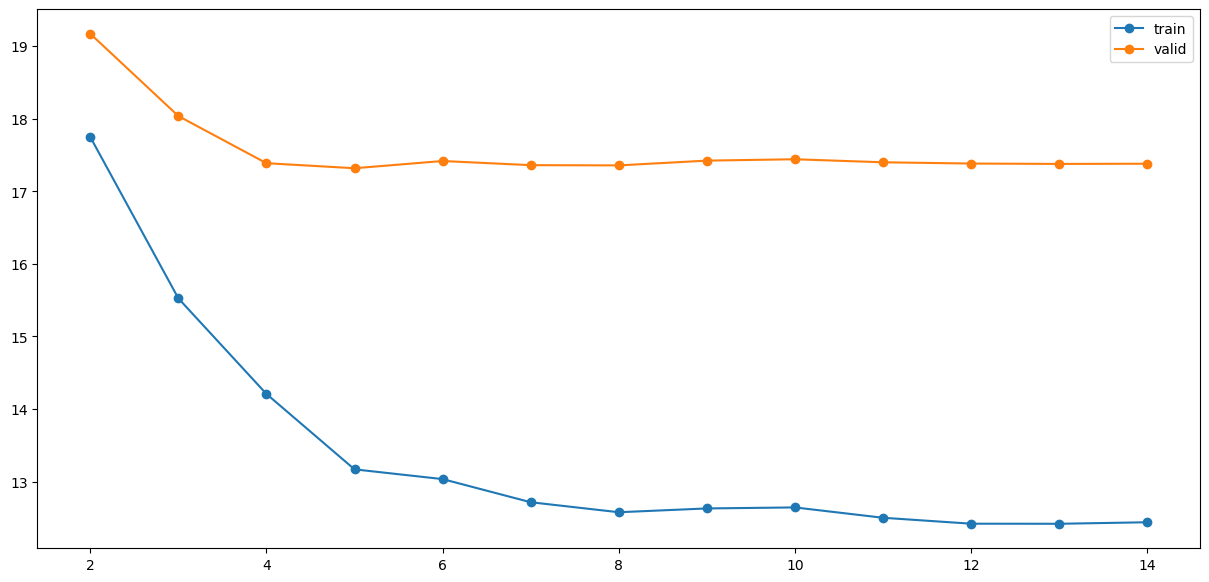

In [27]:
plt.figure(figsize=(15,7))
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmse_train'],label='train',marker='o');
plt.plot(max_depth_results['depth'], max_depth_results['mean_rmse_valid'],label='valid',marker='o');
plt.legend();

In [34]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# Define RMSLE function
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

def get_min_child_weight_lgb(evaluation_set):
    results = []
    
    for min_child_samples in range(1, 6, 1):  # Testing values from 1 to 5
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            # Separate the independent and target variables
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # Define LightGBM Model
            model = lgb.LGBMRegressor(
                n_estimators=720,  # Keeping n_estimators fixed
                max_depth=4,  # Fixed depth
                min_child_samples=min_child_samples,  # LightGBM equivalent of min_child_weight
                learning_rate=0.01,
                n_jobs=4,
                random_state=0,
                objective='regression',
                metric='rmse'  # RMSE for evaluation
            )

            # Fit the model
            model.fit(
                train_data_x, train_data_y,
                eval_set=[(valid_data_x, valid_data_y)],  # Only validation set for eval
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
            )

            # Compute RMSLE manually
            y_train_pred = model.predict(train_data_x)
            y_valid_pred = model.predict(valid_data_x)

            rmsle_train = rmsle(train_data_y, y_train_pred)
            rmsle_valid = rmsle(valid_data_y, y_valid_pred)

            SCORE_TRAIN.append(rmsle_train)
            SCORE_VALID.append(rmsle_valid)

        # Calculate mean RMSLE for train and valid sets
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'With Min Child Samples: {mcw}\t MEAN RMSLE TRAIN: {mean_score_train:.4f}\t MEAN RMSLE VALID: {mean_score_valid:.4f}')
        
        x['min_child_samples'] = min_child_samples
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame(results)


In [35]:
mcw_results = get_min_child_weight_lgb(evaluation_set)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 36
[LightGBM] [Info] Start training from score 27.764459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

NameError: name 'mcw' is not defined

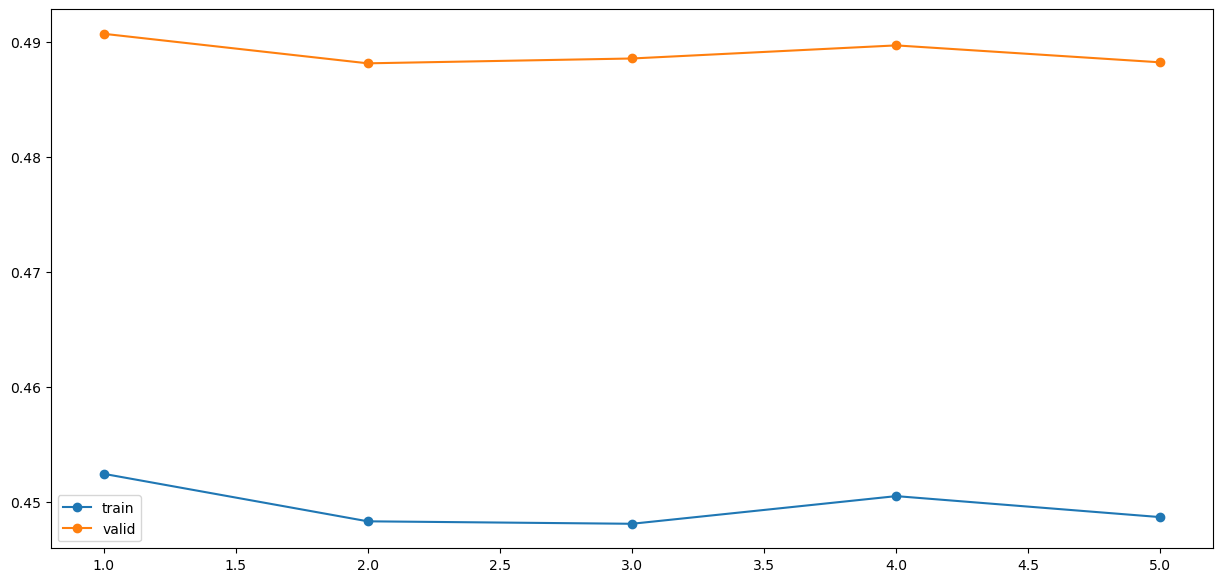

In [36]:
plt.figure(figsize=(15,7))
plt.plot(mcw_results['min_child_samples'], mcw_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(mcw_results['min_child_samples'], mcw_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

In [37]:
import lightgbm as lgb
import numpy as np
import pandas as pd

# Define RMSLE function
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

def get_lambda_l1_lgb(evaluation_set):
    results = []
    
    for l1_reg in [0, 0.01, 0.1, 0.5, 1, 10, 100]:  # Equivalent to XGBoost gamma
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            # Separate the independent and target variables
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            # Define LightGBM Model with lambda_l1 (L1 regularization)
            model = lgb.LGBMRegressor(
                n_estimators=720,  # Keeping n_estimators fixed
                max_depth=4,  # Fixed depth
                min_child_samples=2,  # Equivalent to XGBoost min_child_weight
                lambda_l1=l1_reg,  # Equivalent to gamma in XGBoost
                learning_rate=0.01,
                n_jobs=4,
                random_state=0,
                objective='regression',
                metric='rmse'  # RMSE for evaluation
            )

            # Fit the model
            model.fit(
                train_data_x, train_data_y,
                eval_set=[(valid_data_x, valid_data_y)],  # Only validation set for eval
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
            )

            # Compute RMSLE manually
            y_train_pred = model.predict(train_data_x)
            y_valid_pred = model.predict(valid_data_x)

            rmsle_train = rmsle(train_data_y, y_train_pred)
            rmsle_valid = rmsle(valid_data_y, y_valid_pred)

            SCORE_TRAIN.append(rmsle_train)
            SCORE_VALID.append(rmsle_valid)

        # Calculate mean RMSLE for train and valid sets
        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'With lambda_l1 (XGBoost gamma equivalent): {l1_reg}\t MEAN RMSLE TRAIN: {mean_score_train:.4f}\t MEAN RMSLE VALID: {mean_score_valid:.4f}')
        
        x['lambda_l1'] = l1_reg
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame(results)


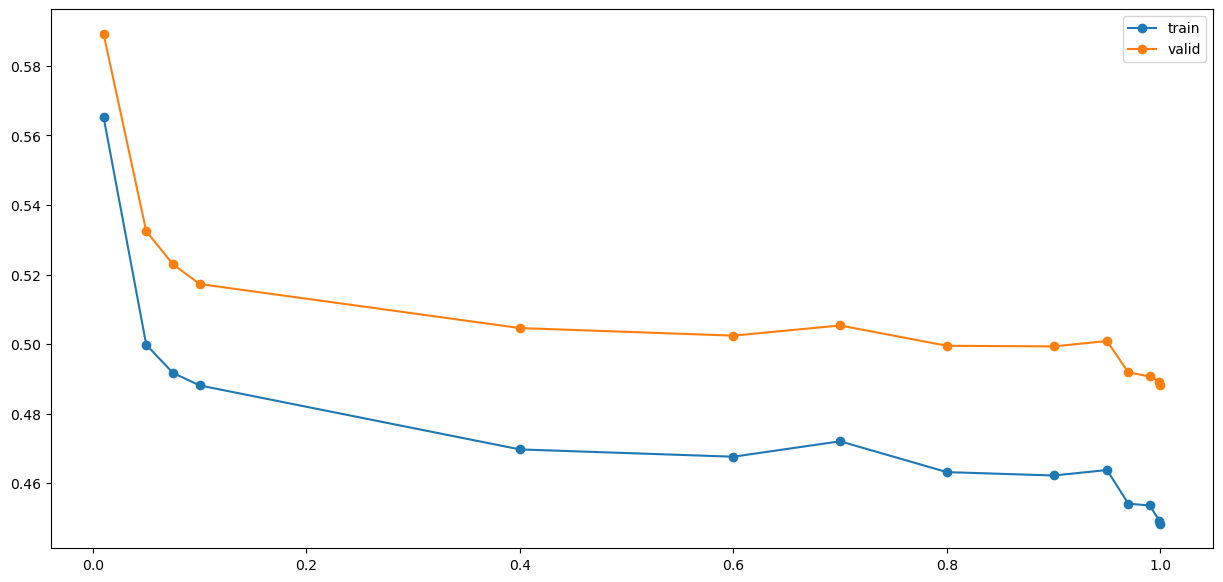

In [46]:
plt.figure(figsize=(15,7))
plt.plot(bagging_fraction_results['bagging_fraction'], bagging_fraction_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(bagging_fraction_results['bagging_fraction'], bagging_fraction_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

In [ ]:
gamma_results= get_lambda_l1_lgb(evaluation_set)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features: 36
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Info] Start training from score 27.764459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

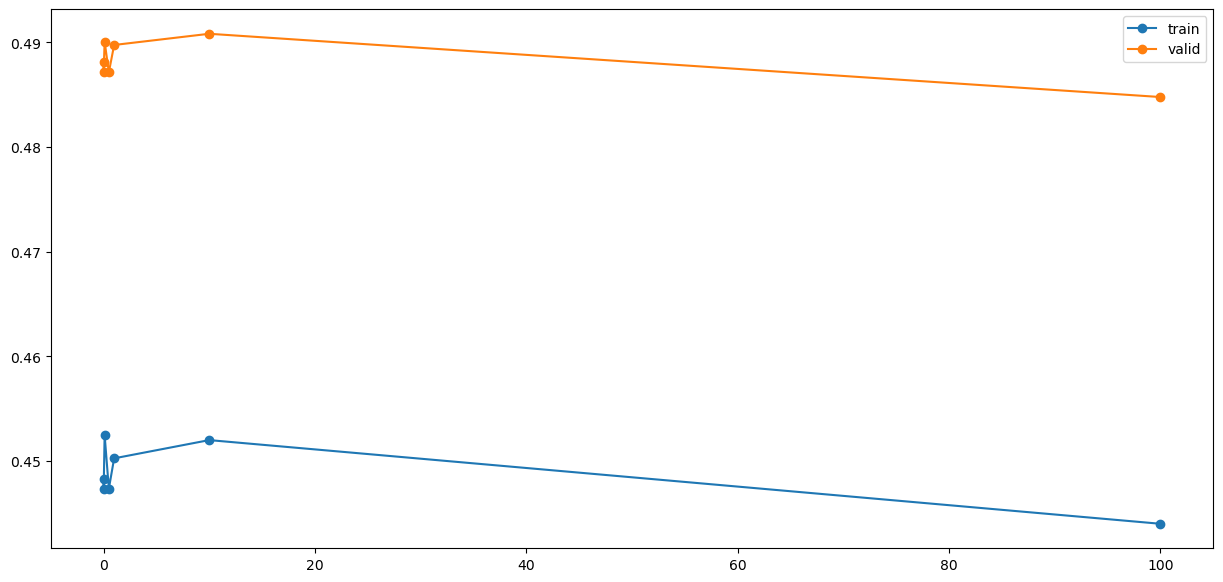

In [42]:
plt.figure(figsize=(15,7))
plt.plot(gamma_results['lambda_l1'], gamma_results['mean_rmsle_train'],label='train',marker='o');
plt.plot(gamma_results['lambda_l1'], gamma_results['mean_rmsle_valid'],label='valid',marker='o');
plt.legend();

In [43]:
import lightgbm as lgb
import numpy as np
import pandas as pd

def rmsle(y_true, y_pred):
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

def get_bagging_fraction_lgb(evaluation_set):
    results = []
    
    for bagging_fraction in [0.01, 0.05, 0.075, 0.1, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 0.99, 0.999, 1]:
        x = {}
        SCORE_TRAIN = []
        SCORE_VALID = []
        
        for train, valid in evaluation_set:
            train_data_x = train.drop(columns=['WEEK_END_DATE', 'UNITS'])
            train_data_y = train['UNITS']
            valid_data_x = valid.drop(columns=['WEEK_END_DATE', 'UNITS'])
            valid_data_y = valid['UNITS']

            model = lgb.LGBMRegressor(
                n_estimators=720,
                bagging_fraction=bagging_fraction,
                bagging_freq=5,
                max_depth=4,
                min_child_samples=2,
                lambda_l1=0,
                learning_rate=0.01,
                n_jobs=4,
                random_state=0,
                objective='regression',
                metric='rmse'
            )

            model.fit(
                train_data_x, train_data_y,
                eval_set=[(valid_data_x, valid_data_y)],
                eval_metric='rmse',
                callbacks=[lgb.early_stopping(stopping_rounds=10, verbose=False)]
            )

            # Compute RMSLE manually
            y_train_pred = model.predict(train_data_x)
            y_valid_pred = model.predict(valid_data_x)

            rmsle_train = rmsle(train_data_y, y_train_pred)
            rmsle_valid = rmsle(valid_data_y, y_valid_pred)

            SCORE_TRAIN.append(rmsle_train)
            SCORE_VALID.append(rmsle_valid)

        mean_score_train = np.mean(SCORE_TRAIN)
        mean_score_valid = np.mean(SCORE_VALID)
        
        print(f'With Bagging Fraction (XGBoost subsample equivalent): {bagging_fraction}\t MEAN RMSLE TRAIN: {mean_score_train:.4f}\t MEAN RMSLE VALID: {mean_score_valid:.4f}')
        
        x['bagging_fraction'] = bagging_fraction
        x['mean_rmsle_train'] = mean_score_train
        x['mean_rmsle_valid'] = mean_score_valid
        results.append(x)
    
    return pd.DataFrame(results)


In [ ]:
bagging_fraction_results = get_bagging_fraction_lgb(evaluation_set)

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.01, subsample=1.0 will be ignored. Current value: bagging_fraction=0.01
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 13089, number of used features